
# Account for spectral absorption due to the EBL

Gamma rays emitted from extra-galactic objects, eg blazars, interact
with the photons of the Extragalactic Background Light (EBL) through
pair production and are attenuated, thus modifying the intrinsic
spectrum.

Various models of the EBL are supplied in `GAMMAPY_DATA`. This
notebook shows how to use these models to correct for this interaction.


## Setup

As usual, we’ll start with the standard imports …




In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
from gammapy.catalog import SourceCatalog4FGL
from gammapy.datasets import SpectrumDatasetOnOff
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    EBL_DATA_BUILTIN,
    EBLAbsorptionNormSpectralModel,
    GaussianPrior,
    PowerLawSpectralModel,
    SkyModel,
)

## Load the data

We will use 6 observations of the blazars PKS 2155-304 taken in 2008 by
H.E.S.S. when it was in a steady state. The data have already been
reduced to OGIP format `SpectrumDatasetOnOff` following the procedure
:doc:`/tutorials/analysis-1d/spectral_analysis` tutorial using a
`ReflectedRegions` background estimation. The spectra and IRFs from the
6 observations have been stacked together.

We will load this dataset as a `~gammapy.datasets.SpectrumDatasetOnOff` and proceed with
the modeling. You can do a 3D analysis as well.




In [2]:
dataset = SpectrumDatasetOnOff.read(
    "$GAMMAPY_DATA/PKS2155-steady/pks2155-304_steady.fits.gz"
)

print(dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 119 
  Total background counts         : 37.75
  Total excess counts             : 81.25

  Predicted counts                : 44.00
  Predicted background counts     : 44.00
  Predicted excess counts         : nan

  Exposure min                    : 3.80e+05 m2 s
  Exposure max                    : 2.68e+09 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 8 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 109.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 453 
  Acceptance                      : 8 
  Acceptance off                  : 96 



## Model the observed spectrum

The observed spectrum is already attenuated due to the EBL. Assuming
that the intrinsic spectrum is a power law, the observed spectrum is a
`gammapy.modeling.models.CompoundSpectralModel` given by the product of an EBL model with the
intrinsic model.




For a list of available models, see
:doc:`/api/gammapy.modeling.models.EBL_DATA_BUILTIN`.




In [3]:
print(EBL_DATA_BUILTIN.keys())

dict_keys(['franceschini', 'dominguez', 'finke', 'franceschini17', 'saldana-lopez21'])


To use other EBL models, you need to save the optical depth as a
function of energy and redshift as an XSPEC model.
Alternatively, you can use packages like [ebltable](https://github.com/me-manu/ebltable)
which shows how to interface other EBL models with Gammapy.




Define the power law




In [4]:
index = 2.3
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
pwl = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)
pwl.index.frozen = False
# Specify the redshift of the source
redshift = 0.116

# Load the EBL model. Here we use the model from Dominguez, 2011
absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)


# The power-law model is multiplied by the EBL to get the final model
spectral_model = pwl * absorption
print(spectral_model)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

type    name     value         unit        error   min max frozen link prior
---- --------- ---------- -------------- --------- --- --- ------ ---- -----
         index 2.3000e+00                0.000e+00 nan nan  False           
     amplitude 1.8100e-12 TeV-1 s-1 cm-2 0.000e+00 nan nan  False           
     reference 1.0000e+00            TeV 0.000e+00 nan nan   True           
    Component 2 : EBLAbsorptionNormSpectralModel

type    name      value    unit   error   min max frozen link prior
---- ---------- ---------- ---- --------- --- --- ------ ---- -----
     alpha_norm 1.0000e+00      0.000e+00 nan nan   True           
       redshift 1.1600e-01      0.000e+00 nan nan   True           
    Operator : mul



Now, create a sky model and proceed with the fit




In [5]:
sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="pks2155")

dataset.models = sky_model

Note that since this dataset has been produced
by a reflected region analysis, it uses ON-OFF statistic
and does not require a background model.




In [6]:
fit = Fit()
result = fit.run(datasets=[dataset])

# we make a copy here to compare it later
model_best = sky_model.copy()

print(result.models.to_parameters_table())

 model  type    name      value         unit      ... min max frozen link prior
------- ---- ---------- ---------- -------------- ... --- --- ------ ---- -----
pks2155           index 2.5531e+00                ... nan nan  False           
pks2155       amplitude 1.2978e-11 TeV-1 s-1 cm-2 ... nan nan  False           
pks2155       reference 1.0000e+00            TeV ... nan nan   True           
pks2155      alpha_norm 1.0000e+00                ... nan nan   True           
pks2155        redshift 1.1600e-01                ... nan nan   True           


# Get the flux points

To get the observed flux points, just run the `~gammapy.estimators.FluxPointsEstimator`
normally




In [7]:
energy_edges = dataset.counts.geom.axes["energy"].edges
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="pks2155", selection_optional="all"
)
flux_points_obs = fpe.run(datasets=[dataset])

To get the deabsorbed flux points (ie, intrinsic points), we simply need
to set the reference model to the best fit power law instead of the
compound model.




In [8]:
flux_points_intrinsic = flux_points_obs.copy(
    reference_model=SkyModel(spectral_model=pwl)
)

#
print(flux_points_obs.reference_model)

#
print(flux_points_intrinsic.reference_model)

Changing the reference model will change the fluxes. Handle with care.


SkyModel

  Name                      : yUGEZldc
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.553   +/-    0.30             
    amplitude                     :   1.30e-11   +/- 1.9e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   


SkyModel

  Name                      : zj4xUidM
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.553   +/-    0.30             
    amplitude                     :   1.30e-11   +/- 1.9e-12 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         




## Plot the observed and intrinsic fluxes




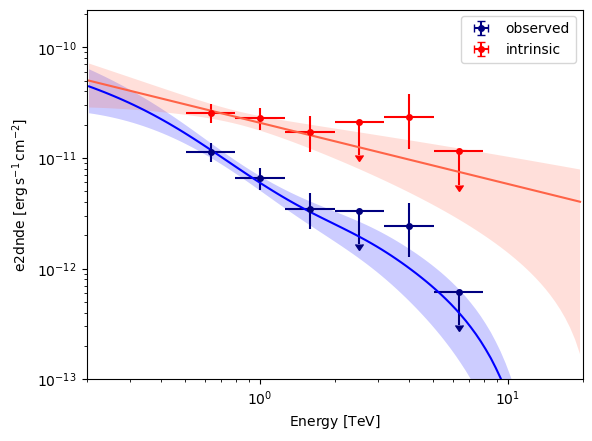

In [9]:
plt.figure()
sed_type = "e2dnde"
energy_bounds = [0.2, 20] * u.TeV
ax = flux_points_obs.plot(sed_type=sed_type, label="observed", color="navy")
flux_points_intrinsic.plot(ax=ax, sed_type=sed_type, label="intrinsic", color="red")

model_best.spectral_model.plot(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="blue"
)
model_best.spectral_model.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type="e2dnde", facecolor="blue"
)

pwl.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, color="tomato")
pwl.plot_error(
    ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, facecolor="tomato"
)
plt.ylim(bottom=1e-13)
plt.legend()
plt.show()
# sphinx_gallery_thumbnail_number = 2

## Further extensions

In this notebook, we have kept the parameters of the EBL model, the
`alpha_norm` and the `redshift` frozen. Under reasonable assumptions
on the intrinsic spectrum, it can be possible to constrain these
parameters.

Example: We now assume that the FermiLAT 4FGL catalog spectrum of the
source is a good assumption of the intrinsic spectrum.

*NOTE*: This is a very simplified assumption and in reality, EBL
absorption can affect the Fermi spectrum significantly. Also, blazar
spectra vary with time and long term averaged states may not be
representative of a specific steady state




In [10]:
catalog = SourceCatalog4FGL()

src = catalog["PKS 2155-304"]

# Get the intrinsic model
intrinsic_model = src.spectral_model()
print(intrinsic_model)

LogParabolaSpectralModel

type    name     value         unit        error   min max frozen link prior
---- --------- ---------- -------------- --------- --- --- ------ ---- -----
     amplitude 1.2591e-11 MeV-1 s-1 cm-2 1.317e-13 nan nan  False           
     reference 1.1610e+03            MeV 0.000e+00 nan nan   True           
         alpha 1.7733e+00                1.029e-02 nan nan  False           
          beta 4.1893e-02                3.743e-03 nan nan  False           


We add Gaussian priors on the `alpha` and `beta` parameters based on the 4FGL
measurements and the associated errors. For more details on using priors, see
:doc:`/tutorials/api/priors`




In [11]:
intrinsic_model.alpha.prior = GaussianPrior(
    mu=intrinsic_model.alpha.value, sigma=intrinsic_model.alpha.error
)
intrinsic_model.beta.prior = GaussianPrior(
    mu=intrinsic_model.beta.value, sigma=intrinsic_model.beta.error
)

As before, multiply the intrinsic model with the EBL model




In [12]:
obs_model = intrinsic_model * absorption

Now, free the redshift of the source




In [13]:
obs_model.parameters["redshift"].frozen = False

print(obs_model.parameters.to_table())

sky_model = SkyModel(spectral_model=obs_model, name="observed")
dataset.models = sky_model

result1 = fit.run([dataset])

print(result1.parameters.to_table())

type    name      value         unit      ... max frozen link     prior    
---- ---------- ---------- -------------- ... --- ------ ---- -------------
      amplitude 1.2591e-11 MeV-1 s-1 cm-2 ... nan  False                   
      reference 1.1610e+03            MeV ... nan   True                   
          alpha 1.7733e+00                ... nan  False      GaussianPrior
           beta 4.1893e-02                ... nan  False      GaussianPrior
     alpha_norm 1.0000e+00                ... nan   True                   
       redshift 1.1600e-01                ... nan  False                   
type    name      value         unit      ... max frozen link     prior    
---- ---------- ---------- -------------- ... --- ------ ---- -------------
      amplitude 1.9692e-11 MeV-1 s-1 cm-2 ... nan  False                   
      reference 1.1610e+03            MeV ... nan   True                   
          alpha 1.7733e+00                ... nan  False      GaussianPrior
           b

## Get a fit stat profile for the redshift

For more information about stat profiles, see
:doc:`/tutorials/api/fitting`




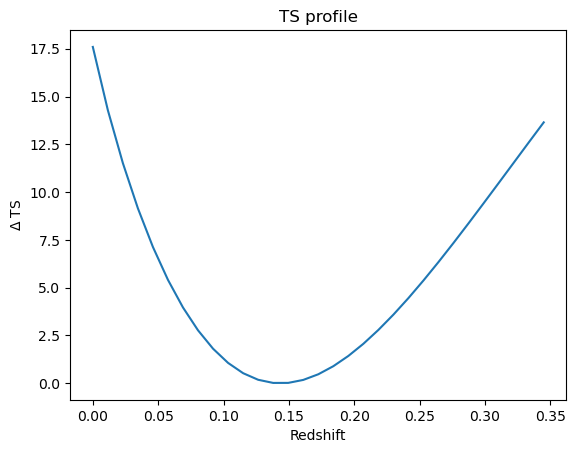

In [14]:
total_stat = result1.total_stat

par = sky_model.parameters["redshift"]
par.scan_max = par.value + 5.0 * par.error
par.scan_min = max(0, par.value - 5.0 * par.error)
par.scan_n_values = 31

# %time
profile = fit.stat_profile(
    datasets=[dataset], parameter=sky_model.parameters["redshift"], reoptimize=True
)

plt.figure()
ax = plt.gca()
ax.plot(
    profile["observed.spectral.model2.redshift_scan"], profile["stat_scan"] - total_stat
)
ax.set_title("TS profile")
ax.set_xlabel("Redshift")
ax.set_ylabel("$\Delta$ TS")
plt.show()

We see that the redshift is well constrained.


